# Capstone Project Model Test (LSTM)

## Library & Utility

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


%matplotlib inline

In [4]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Data Preparation

In [5]:
data_df = pd.read_csv('../data/cleans/dataset_cmbtt.csv')
data_df

,tanggal,jenis,qty,harga,jumlah
0,2023-05-10,CMBTT,742.000000,18000.0,1.335600e+07
1,2023-05-11,CMBTT,1258.000000,36000.0,2.264400e+07
2,2023-05-12,CMBTT,1156.500000,33000.0,2.714700e+07
3,2023-05-13,CMBTT,1055.000000,30000.0,3.165000e+07
4,2023-05-14,CMBTT,769.000000,30000.0,2.307000e+07
...,...,...,...,...,...
371,2024-05-14,CMBTT,1973.500000,110500.0,6.579850e+07
372,2024-05-15,CMBTT,1949.000000,100000.0,6.524500e+07
373,2024-05-16,CMBTT,1323.333333,78000.0,4.431267e+07
374,2024-05-17,CMBTT,697.666667,56000.0,2.338033e+07


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tanggal  376 non-null    object 
 1   jenis    376 non-null    object 
 2   qty      376 non-null    float64
 3   harga    376 non-null    float64
 4   jumlah   376 non-null    float64
dtypes: float64(3), object(2)
memory usage: 14.8+ KB


In [9]:
# Copy dataframe
df_copy = data_df.copy()

# Convert tipe data
df_copy['qty'] = df_copy['qty'].astype(int)
df_copy['harga'] = df_copy['harga'].astype(int)
df_copy['jumlah'] = df_copy['jumlah'].astype(int)
df_copy['tanggal'] = pd.to_datetime(df_copy['tanggal'], format='mixed')
df_copy.set_index('tanggal', inplace=True)

In [10]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376 entries, 2023-05-10 to 2024-05-18
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   jenis   376 non-null    object
 1   qty     376 non-null    int32 
 2   harga   376 non-null    int32 
 3   jumlah  376 non-null    int32 
dtypes: int32(3), object(1)
memory usage: 10.3+ KB


In [11]:
df_copy

,jenis,qty,harga,jumlah
tanggal,,,,
2023-05-10,CMBTT,742,18000,13356000
2023-05-11,CMBTT,1258,36000,22644000
2023-05-12,CMBTT,1156,33000,27147000
2023-05-13,CMBTT,1055,30000,31650000
2023-05-14,CMBTT,769,30000,23070000
...,...,...,...,...
2024-05-14,CMBTT,1973,110500,65798500
2024-05-15,CMBTT,1949,100000,65245000
2024-05-16,CMBTT,1323,78000,44312666


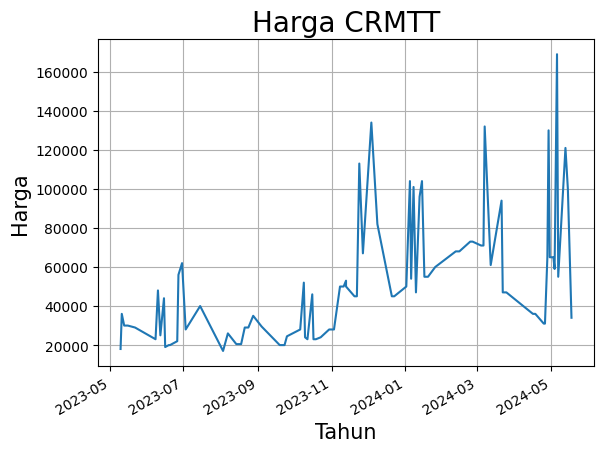

In [13]:
# Plot price
df_copy['harga'].plot(grid = True)
plt.title("Harga CRMTT", color = 'black', fontsize = 20)
plt.xlabel('Tahun', color = 'black', fontsize = 15)
plt.ylabel('Harga', color = 'black', fontsize = 15)
plt.show()

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.map(lambda window: (window[:-1], window[-1]))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [16]:
window_size = 10
batch_size = 32
shuffle_buffer = len(df_copy)

# Normalizes the data
data_harga = df_copy[['harga']].values
dates = df_copy.index.values
split_time = int(len(data_harga) * 0.8)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit_transform(data_harga)
data_harga = scaler.transform(data_harga)

# Splits the data into training and validation sets
x_train = data_harga[:split_time]
x_valid = data_harga[split_time:]

# Split the dates into training and validation sets
dates_train = dates[:split_time]
dates_valid = dates[split_time:]

# Window the data_harga
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer)

## Training

In [17]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv1D(filters=64, kernel_size=3,
#                          strides=1, activation="relu",
#                          padding='causal', input_shape=[None, 1]),
#   tf.keras.layers.LSTM(64, return_sequences=True),
#   tf.keras.layers.LSTM(64),
#   tf.keras.layers.Dense(30, activation="relu"),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(10, activation="relu"),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(1),
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(units = 64, return_sequences = True, input_shape = [None, 1], activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, activation="tanh"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)

history = model.fit(train_set, epochs=200, validation_data=valid_set)


Epoch 1/200


10/10 [==============================] - 14s 269ms/step - loss: 0.0159 - mae: 0.1355 - val_loss: 0.0145 - val_mae: 0.1297
Epoch 2/200
10/10 [==============================] - 0s 35ms/step - loss: 0.0088 - mae: 0.1004 - val_loss: 0.0161 - val_mae: 0.1090
Epoch 3/200
10/10 [==============================] - 0s 38ms/step - loss: 0.0056 - mae: 0.0840 - val_loss: 0.0150 - val_mae: 0.1014
Epoch 4/200
10/10 [==============================] - 0s 37ms/step - loss: 0.0068 - mae: 0.0770 - val_loss: 0.0136 - val_mae: 0.1127
Epoch 5/200
10/10 [==============================] - 0s 39ms/step - loss: 0.0054 - mae: 0.0812 - val_loss: 0.0137 - val_mae: 0.1123
Epoch 6/200
10/10 [==============================] - 0s 36ms/step - loss: 0.0046 - mae: 0.0693 - val_loss: 0.0149 - val_mae: 0.1199
Epoch 7/200
10/10 [==============================] - 0s 36ms/step - loss: 0.0051 - mae: 0.0685 - val_loss: 0.0139 - val_mae: 0.1085
Epoch 8/200
10/10 [==============================] - 0s 40ms/step - los

In [18]:
path = "./model.h5"
model.save(path)

In [20]:
!tensorflowjs_converter --input_format=keras {path} ./


Traceback (most recent call last):
  File "C:\Users\Aditya\miniconda3\envs\skripsi\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Aditya\miniconda3\envs\skripsi\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\Aditya\miniconda3\envs\skripsi\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\Aditya\miniconda3\envs\skripsi\lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\Aditya\miniconda3\envs\skripsi\lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "C:\Users\Aditya\miniconda3\envs\skripsi\lib\site-packages\tensorflowjs\converters\converter.py", line 38, in <module>
    from tensorflowjs.converters import tf_saved_model_conversion_v2
  File "C:\Users\Aditya\miniconda3\envs\skripsi\lib\site-pa

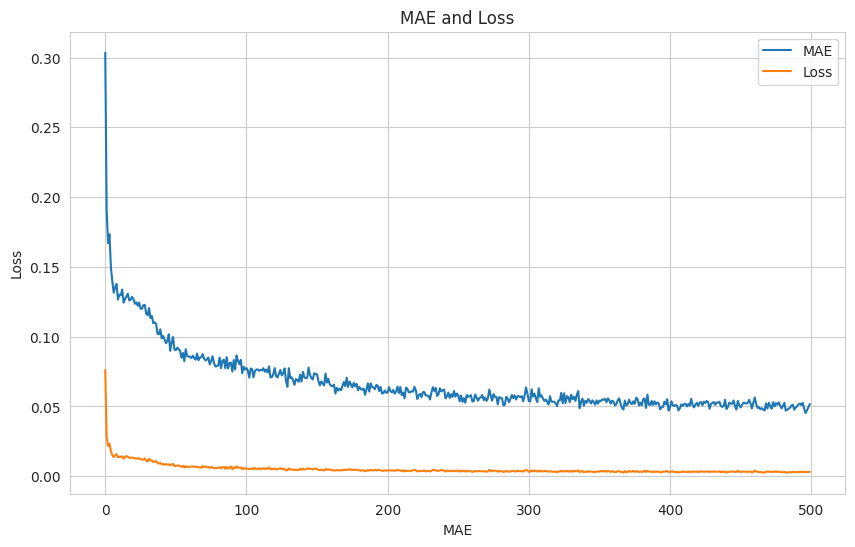

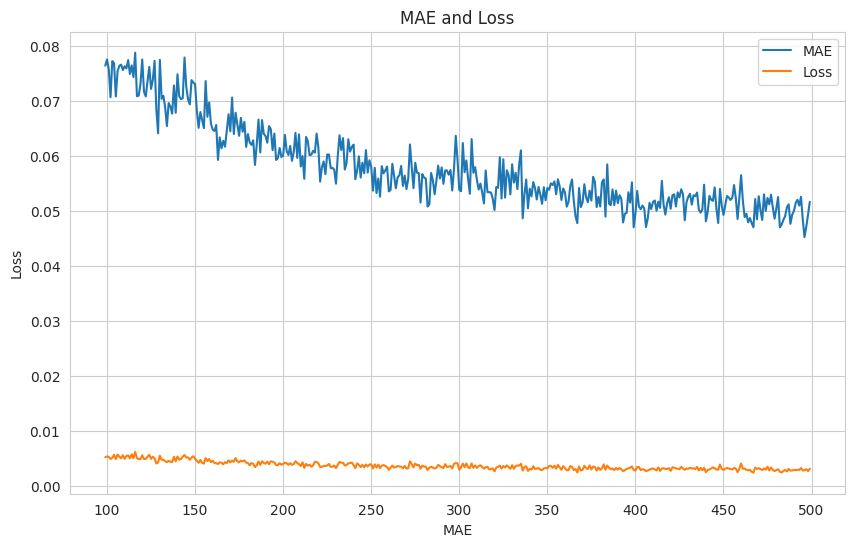

In [54]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Validation

In [55]:
# Print the shape of x_valid before reshaping
print("Shape of x_valid before reshaping:", x_valid.shape)

# Reshape x_valid sesuai dengan kebutuhan model
x_valid_reshaped = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))

# Print the shape of x_valid after reshaping
print("Shape of x_valid after reshaping:", x_valid_reshaped.shape)

# Lakukan prediksi
predictions = model.predict(x_valid_reshaped)

# Inversi normalisasi jika diperlukan
predictions = scaler.inverse_transform(predictions)


Shape of x_valid before reshaping: (42, 1)
Shape of x_valid after reshaping: (42, 1, 1)
2/2 [==============================] - 2s 10ms/step


In [56]:
predictions

array([[82789.98 ],
       [64111.203],
       [64111.203],
       [64111.203],
       [64111.203],
       [54798.305],
       [54798.305],
       [58531.43 ],
       [58531.43 ],
       [58531.43 ],
       [48287.43 ],
       [48287.43 ],
       [48287.43 ],
       [37364.316],
       [37364.316],
       [37364.316],
       [37364.316],
       [37364.316],
       [27825.1  ],
       [21269.125],
       [21269.125],
       [21269.125],
       [21269.125],
       [21269.125],
       [29517.305],
       [29517.305],
       [29517.305],
       [28668.674],
       [28668.674],
       [29517.305],
       [29517.305],
       [29517.305],
       [22874.895],
       [22874.895],
       [21269.125],
       [21269.125],
       [21269.125],
       [20474.86 ],
       [20474.86 ],
       [20474.86 ],
       [25325.645],
       [25325.645]], dtype=float32)

In [57]:
# Menampilkan x_train dan x_valid asli
x_train_original = scaler.inverse_transform(x_train.reshape(-1, 1))
x_valid_original = scaler.inverse_transform(x_valid.reshape(-1, 1))

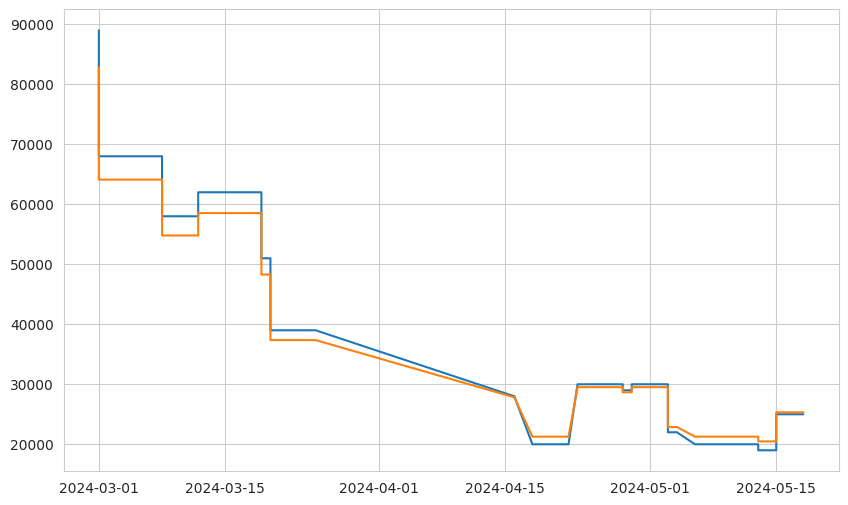

In [58]:
# Plot the results
plot_series(dates_valid, (x_valid_original, predictions))

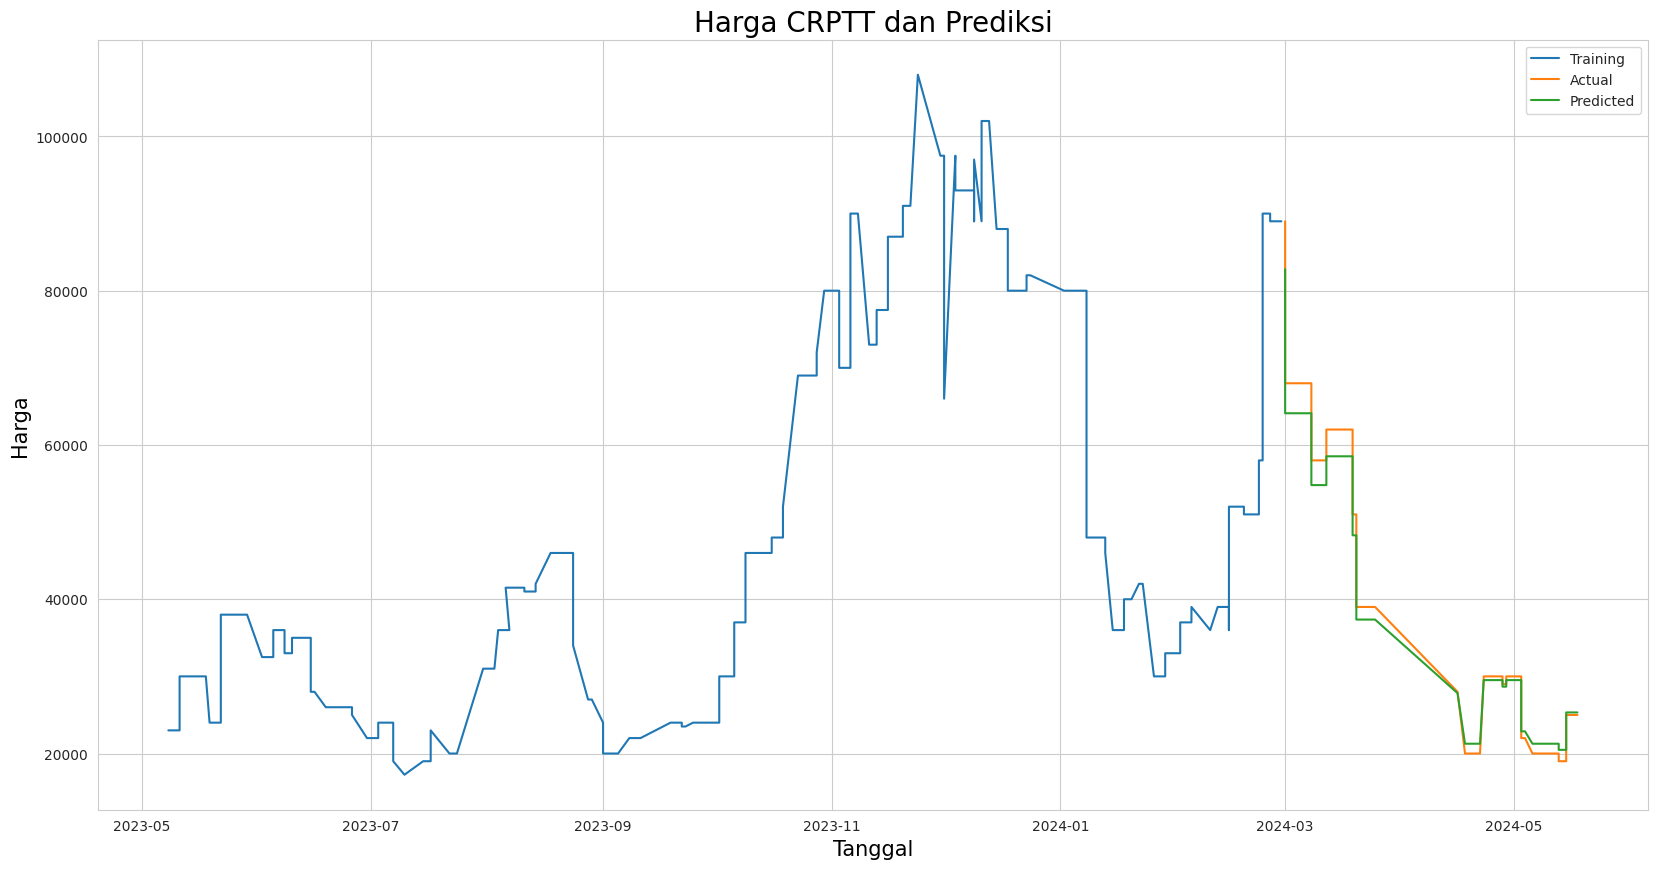

In [59]:
# Plot predicted vs actual values
train = df_copy[:split_time]
test = df_copy[split_time:]

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train.index, train['HARGA'], label='Training')
plt.plot(test.index, test['HARGA'], label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.title("Harga CRPTT dan Prediksi", color='black', fontsize=20)
plt.xlabel('Tanggal', color='black', fontsize=15)
plt.ylabel('Harga', color='black', fontsize=15)
plt.legend()
plt.show()

## Forecasting

In [78]:
# Ambil jendela terakhir dari data validasi sebagai input pertama
last_window = x_valid[-window_size:]
input_data = np.reshape(last_window, (1, window_size, 1))

# Tentukan jumlah langkah waktu ke depan yang ingin Anda prediksi
steps_ahead = 200

# Lakukan peramalan ke depan
forecast = []
for _ in range(steps_ahead):
    # Lakukan prediksi untuk input_data
    prediction = model.predict(input_data)
    # Tambahkan prediksi ke daftar forecast
    forecast.append(prediction[0, 0])
    # Tambahkan prediksi ke input_data untuk langkah waktu berikutnya
    input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inversi normalisasi untuk semua prediksi
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Buat array tanggal untuk langkah waktu ke depan
next_dates = pd.date_range(start=dates_valid[-1], periods=steps_ahead)

1/1 [==============================] - 0s 24ms/step


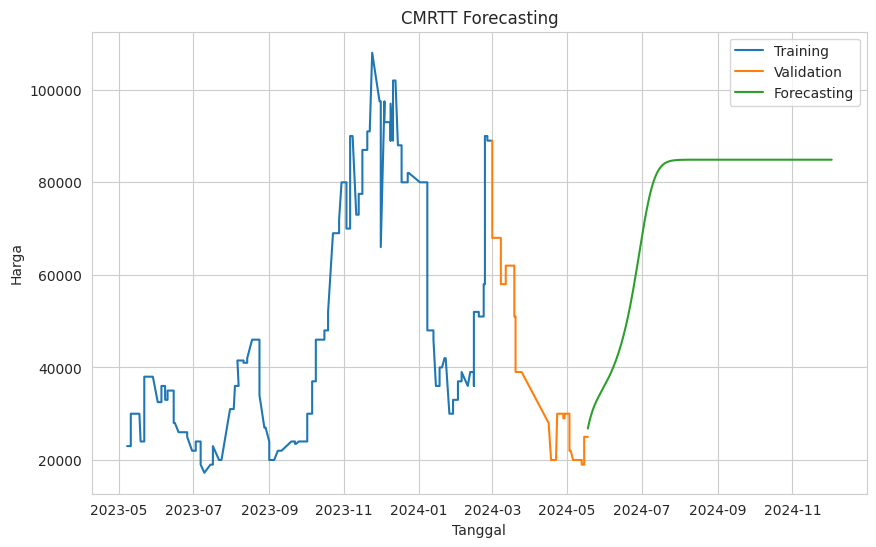

In [81]:
# Plot grafik
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['HARGA'], label='Training')
plt.plot(dates_valid, x_valid_original, label='Validation')
plt.plot(next_dates, forecast, label='Forecasting')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.title('CMRTT Forecasting')
plt.legend()
plt.grid(True)
plt.show()